In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate helical fraction
def betastrand_fraction(ss_line):
    beta_chars = {'E', 'B'}
    n_residues = len(ss_line)
    n_beta = sum(1 for c in ss_line if c in beta_chars)
    return n_beta / n_residues

# function to calculate PPII content
def PPII_fraction(ss_line):
    helix_chars = {'P'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# Function to calculate per-residue PPII per frame
def dssp_to_PPII(dssp_lines):
    """
    Convert DSSP strings into a binary PPII matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('P'), 0 = non-helix.
    """
    helix_codes = {'P'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

output_path = './plots_unb_AAQAA3_274K/'
prod_name = '274K_noHMR'
path = '../Unbiased_MD/AAQAA3_274K/'
path_biased = '../OPES_multiT/AAQAA3/PRODUCTION_OPES_multiT_2fs_noHMR/alldata/'
opes_data_path = './plots_AAQAA3_274K/'

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


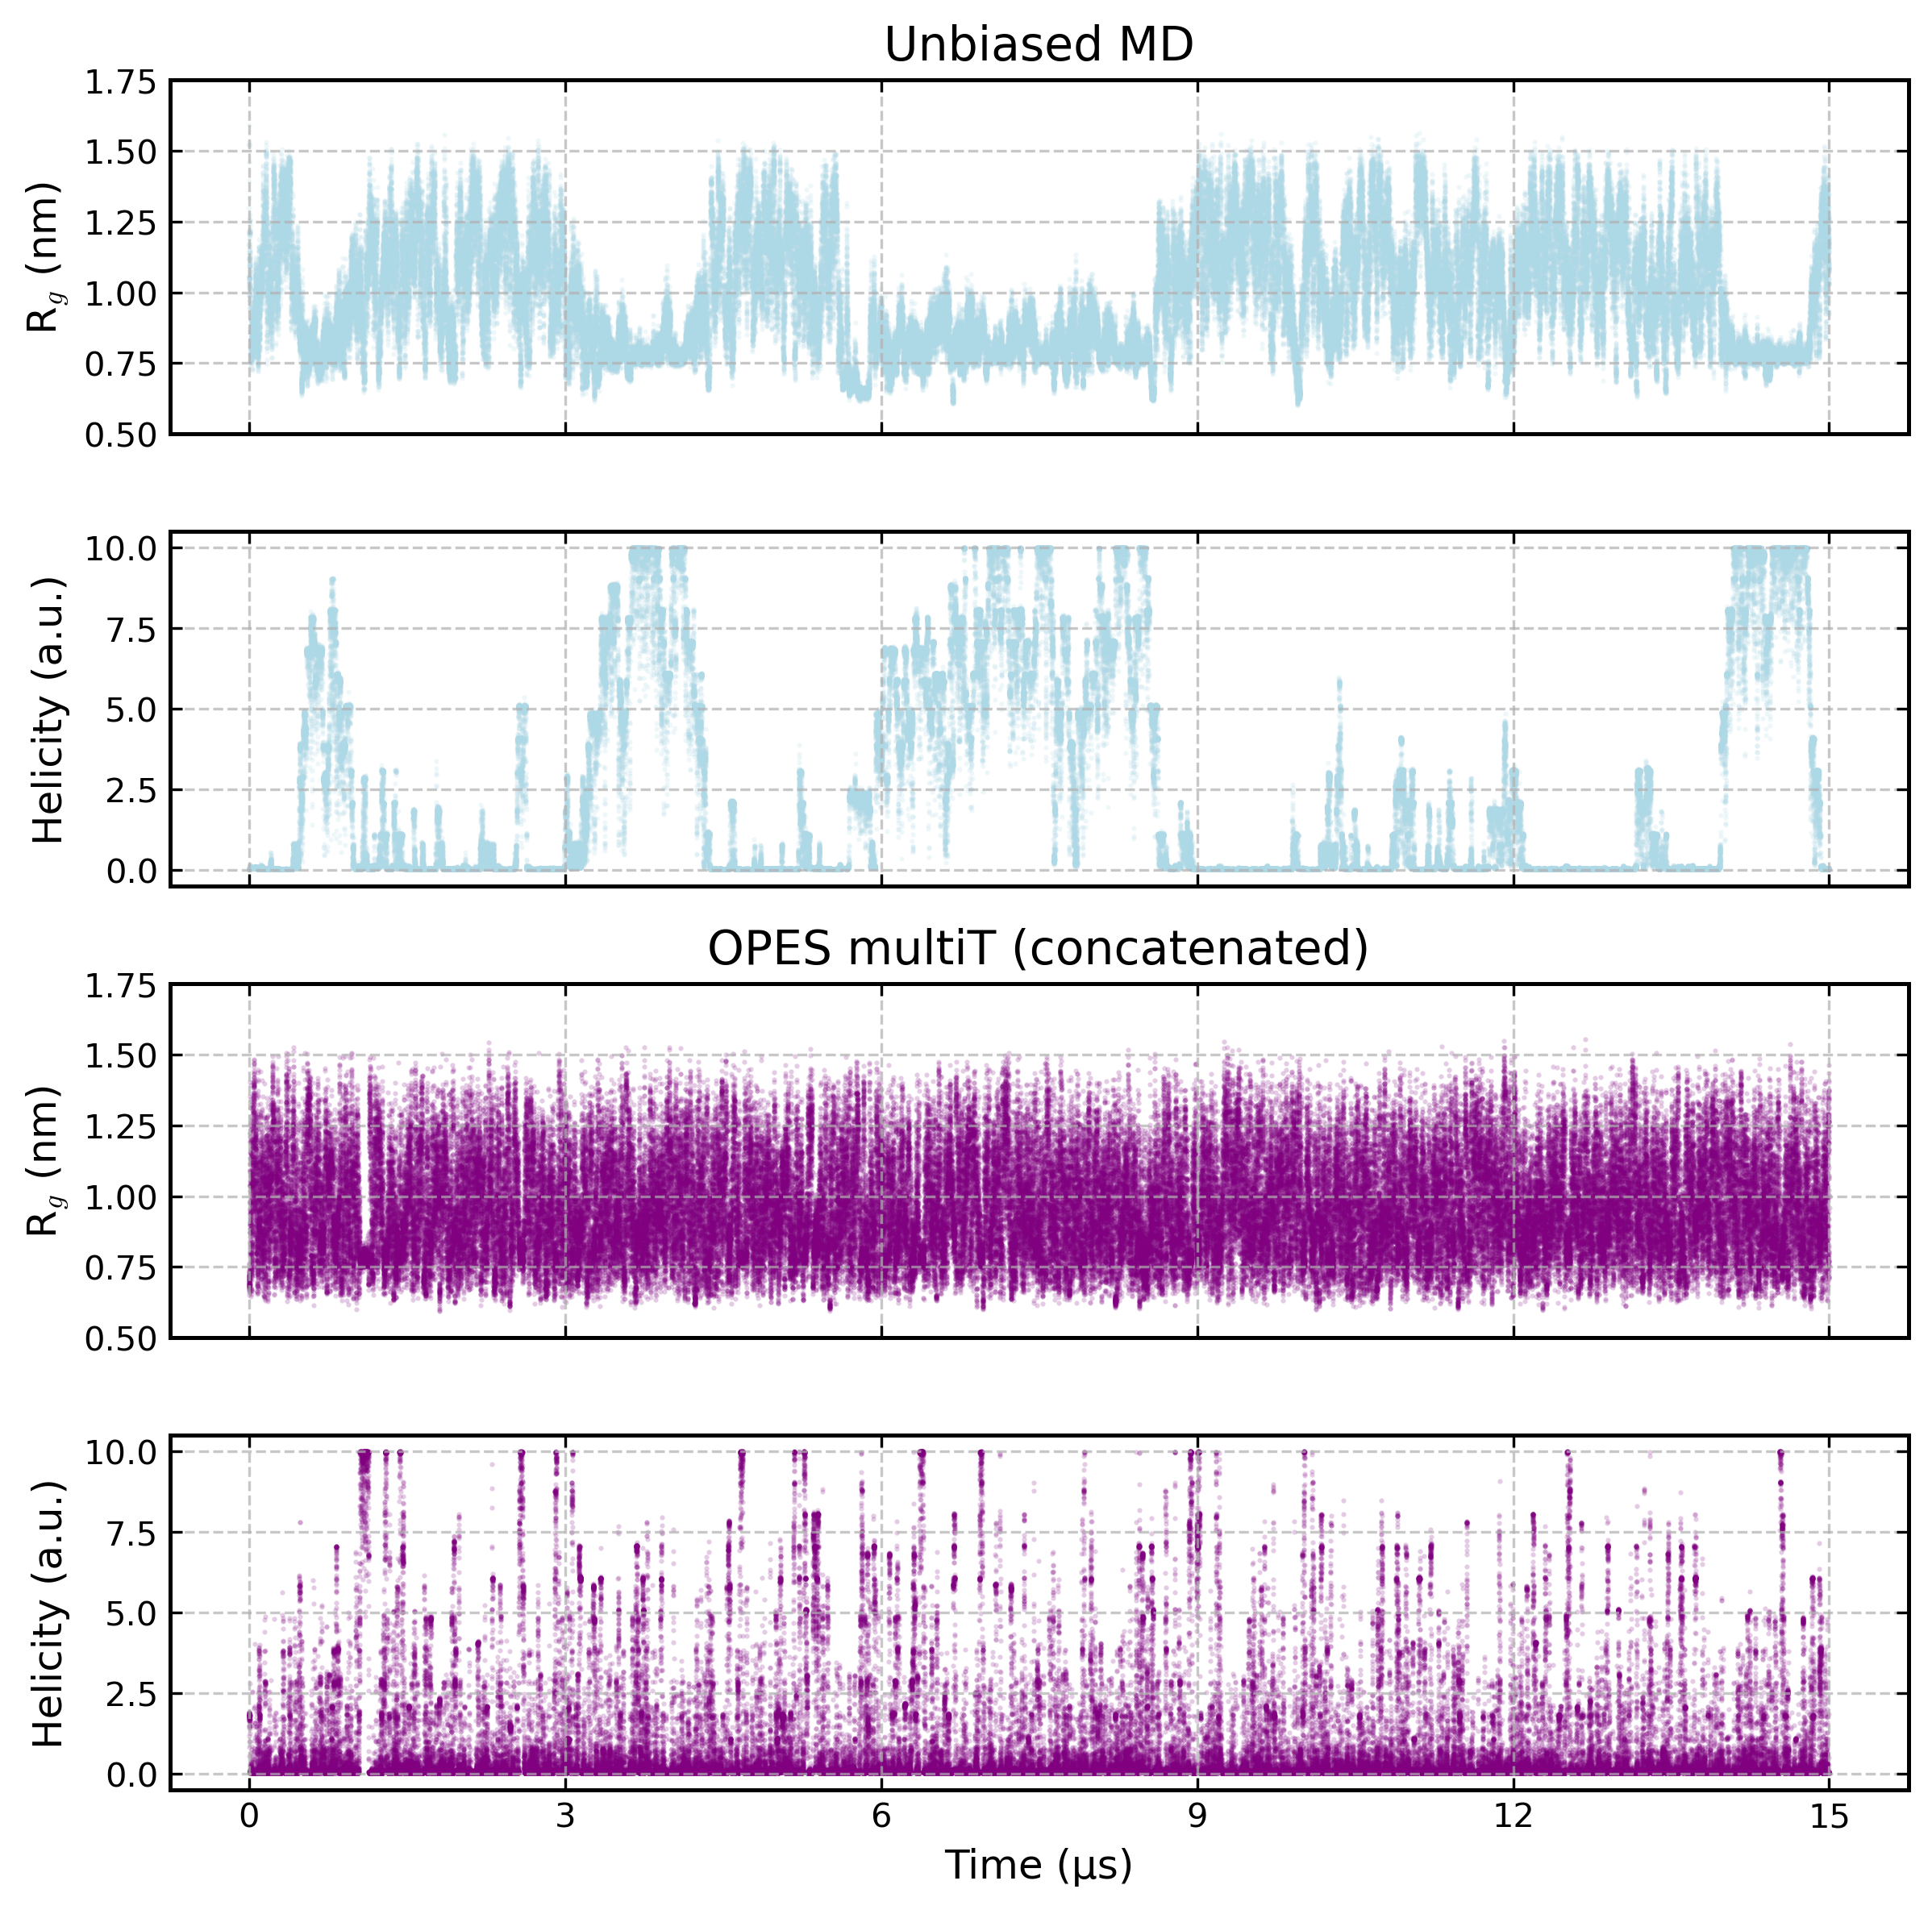

In [2]:
# plot all time evolutions of rg, alpharmsd


nsims_unbiased = 1
nsims_biased = 3
descriptors = ["R$_g$ (nm)", "alphaRMSD"]

fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 8), sharex="col", sharey="row"
)

for sim in range(nsims_unbiased):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
    else:
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        CVS = np.concatenate((CVS, tmpCVS))
    # Time arrays in μs
    time_data = np.arange(CVS.shape[0])/1e4
    # Apply cutoff at 15 µs
    mask_data = time_data <= 15.0 
    time_data = time_data[mask_data]
    CVS = CVS[mask_data]   

# Row 1: Rg
axes[0].scatter(time_data, CVS[:, 1], s=0.25, alpha=0.2, color = 'lightblue', rasterized=True)
axes[0].set_xticks([0, 3, 6, 9, 12, 15])
axes[0].set_xticklabels([0, 3, 6, 9, 12, 15])   
axes[0].set_ylabel("R$_g$ (nm)")
axes[0].set_ylim(0.5,1.75)

# Row 2: alphaRMSD
axes[1].scatter(time_data, CVS[:, 2], s=0.25, alpha=0.2, color = 'lightblue', rasterized=True)
axes[1].set_xticks([0, 3, 6, 9, 12, 15])
axes[1].set_xticklabels([0, 3, 6, 9, 12, 15])   
axes[1].set_ylabel("Helicity (a.u.)")
axes[1].set_ylim(-0.5,10.5)

# Add column titles
axes[0].set_title(f"Unbiased MD")

# biased data
for sim in range(nsims_biased):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path_biased+f'CVS_DATA.{sim}')[::10] # downsample
        # Time arrays in μs
        time_data = np.arange(CVS.shape[0])/1e4
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        CVS = CVS[mask_data]
    else:
        tmpCVS = np.loadtxt(path_biased+f'CVS_DATA.{sim}')[::10] # downsample
        # Time arrays in μs
        time_data = np.arange(tmpCVS.shape[0])/1e4
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpCVS = tmpCVS[mask_data]
        CVS = np.concatenate((CVS, tmpCVS))
     
time_data= np.arange(CVS.shape[0])/1e4

# Row 3: Rg
axes[2].scatter(time_data, CVS[:, 1], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
axes[2].set_xticks([0, 3, 6, 9, 12, 15])
axes[2].set_xticklabels([0, 3, 6, 9, 12, 15])   
axes[2].set_ylabel("R$_g$ (nm)")
axes[2].set_ylim(0.5,1.75)

# Row 4: alphaRMSD
axes[3].scatter(time_data, CVS[:, 2], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
axes[3].set_xticks([0, 3, 6, 9, 12, 15])
axes[3].set_xticklabels([0, 3, 6, 9, 12, 15])   
axes[3].set_ylabel("Helicity (a.u.)")
axes[3].set_xlabel("Time (μs)")
axes[3].set_ylim(-0.5,10.5)

# Add column titles
axes[2].set_title(f"OPES multiT (concatenated)")

    

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_rg_alpha.pdf")



In [3]:
# average Rg at 274K

nsims=1
T=274


# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = np.arange(CVS.shape[0])/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        CVS = CVS[mask_data]

    else:
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = np.arange(tmpCVS.shape[0])/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        tmpCVS = tmpCVS[mask_data]
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# rg of concatenated trajs
rgdata = CVS[:,1]


# run blocking analysis
reblock_data = pyblock.blocking.reblock(rgdata)
opt = pyblock.blocking.find_optimal_block(len(rgdata), reblock_data)[0]
mu = np.mean(rgdata)
std_err = reblock_data[opt][4]


# save data
df = pd.DataFrame()
df['Rg (nm)'] = [np.round(mu, 3)]
df['±'] = [np.round(std_err, 3)]
df.to_csv(output_path+f"{prod_name}_Rg_at_{T}K.csv",index=False)
df
        
    

,Rg (nm),±
0,0.985,0.03


sum probs: 0.9999999999999999


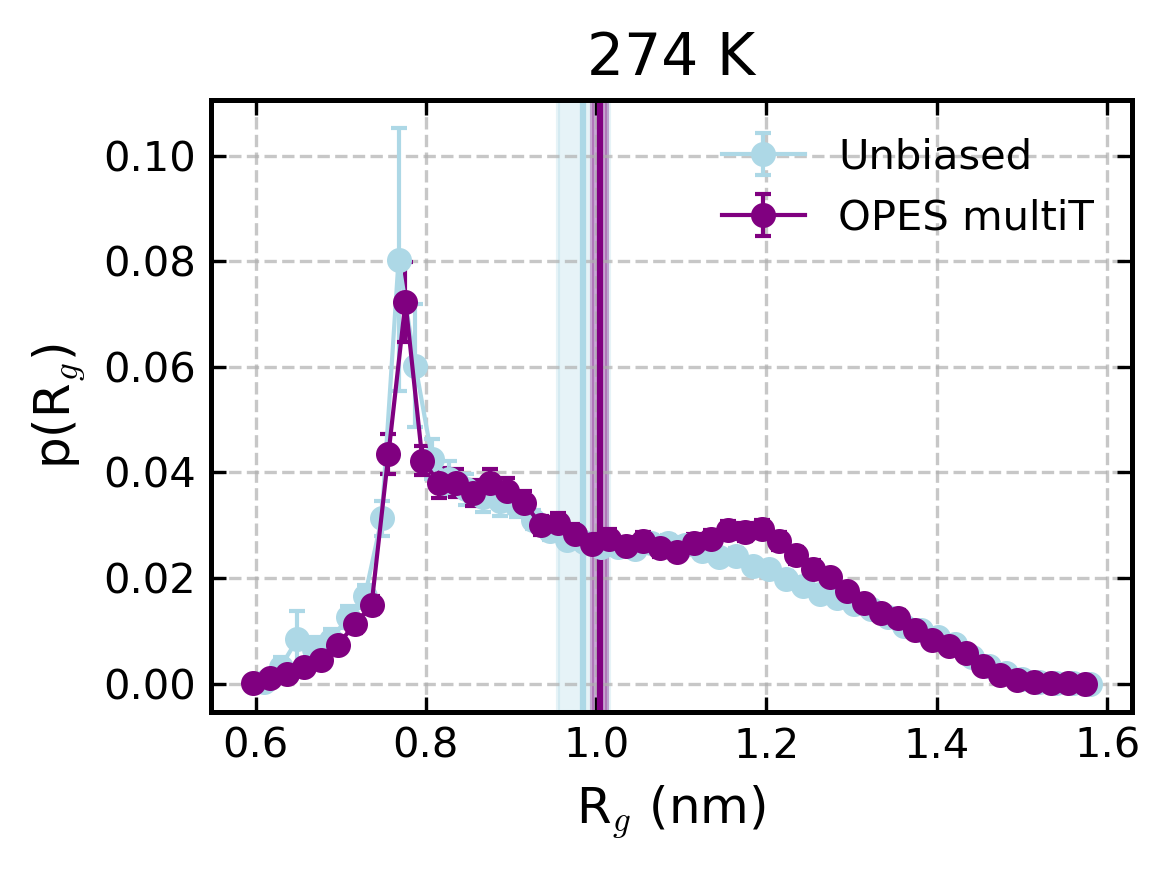

In [5]:
# Rg distribution at 274 K (avg ± std_err) and overlay with OPES multiT 274K

nsims = 1
nbins = 50

# initialise figure
plt.figure(figsize = (4,3))

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = np.arange(CVS.shape[0])/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        CVS = CVS[mask_data]

    else:
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = np.arange(tmpCVS.shape[0])/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        tmpCVS = tmpCVS[mask_data]
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# rg of concatenated trajs
rgdata = CVS[:,1]

# histogram
counts, bin_edges = np.histogram(rgdata, bins=nbins, density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
N = len(rgdata)

probs = np.zeros(nbins)
errs = np.zeros(nbins)

# for each bin build indicator time series and use pyblock
for i in range(nbins):
    left, right = bin_edges[i], bin_edges[i+1]
    # include left edge, exclude right edge except for last bin:
    if i == nbins-1:
        indicator = ((rgdata >= left) & (rgdata <= right)).astype(float)
    else:
        indicator = ((rgdata >= left) & (rgdata < right)).astype(float)

    # if the indicator is constant (no hits or all hits) handle trivially
    if indicator.sum() == 0:
        probs[i] = 0.0
        errs[i] = 0.0
        continue
    if indicator.sum() == N:
        probs[i] = 1.0
        errs[i] = 0.0
        continue

    # run pyblock: reblock returns list-like, find_optimal_block returns index (float -> convert)
    reblocked = pyblock.blocking.reblock(indicator)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(indicator), reblocked)[0])
    mean_bin = np.mean(indicator)
    stderr_bin = reblocked[opt].std_err

    probs[i] = mean_bin
    errs[i] = stderr_bin

# sanity: probabilities should sum approx to 1 (if using counts-->probs per-bin)
print("sum probs:", probs.sum())

# save data
df= pd.DataFrame()
df['Rg (nm)'] = bin_centers
df['p(Rg)'] = probs
df['±'] = errs
df.to_csv(output_path+f"{prod_name}_prob_Rg.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"274 K")
plt.errorbar(bin_centers, probs, yerr=errs, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='lightblue', label='Unbiased')
plt.xlabel("R$_g$ (nm)")
plt.ylabel("p(R$_g$)")

# add OPES multi-T data as a comparison
dfopes = pd.read_csv(opes_data_path+f"{prod_name}_prob_Rg_274K.csv")
plt.errorbar(dfopes['Rg (nm)'], dfopes['p(Rg)'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label = 'OPES multiT')

# load and plot the average rg
avg1 = pd.read_csv(output_path+f"{prod_name}_Rg_at_274K.csv")
avg2 = pd.read_csv(opes_data_path+f"274K_noHMR_Rg_at_274K.csv")

plt.axvline(avg1['Rg (nm)'][0], color = 'lightblue', linewidth=1.5)
plt.axvspan(avg1['Rg (nm)'][0]-avg1['±'][0],avg1['Rg (nm)'][0]+avg1['±'][0], color = 'lightblue', alpha=0.3)
plt.axvline(avg2['Rg (nm)'][0], color = 'purple', linewidth=1.5)
plt.axvspan(avg2['Rg (nm)'][0]-avg2['±'][0],avg2['Rg (nm)'][0]+avg2['±'][0], color = 'purple', alpha=0.3)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_prob_Rg.pdf")

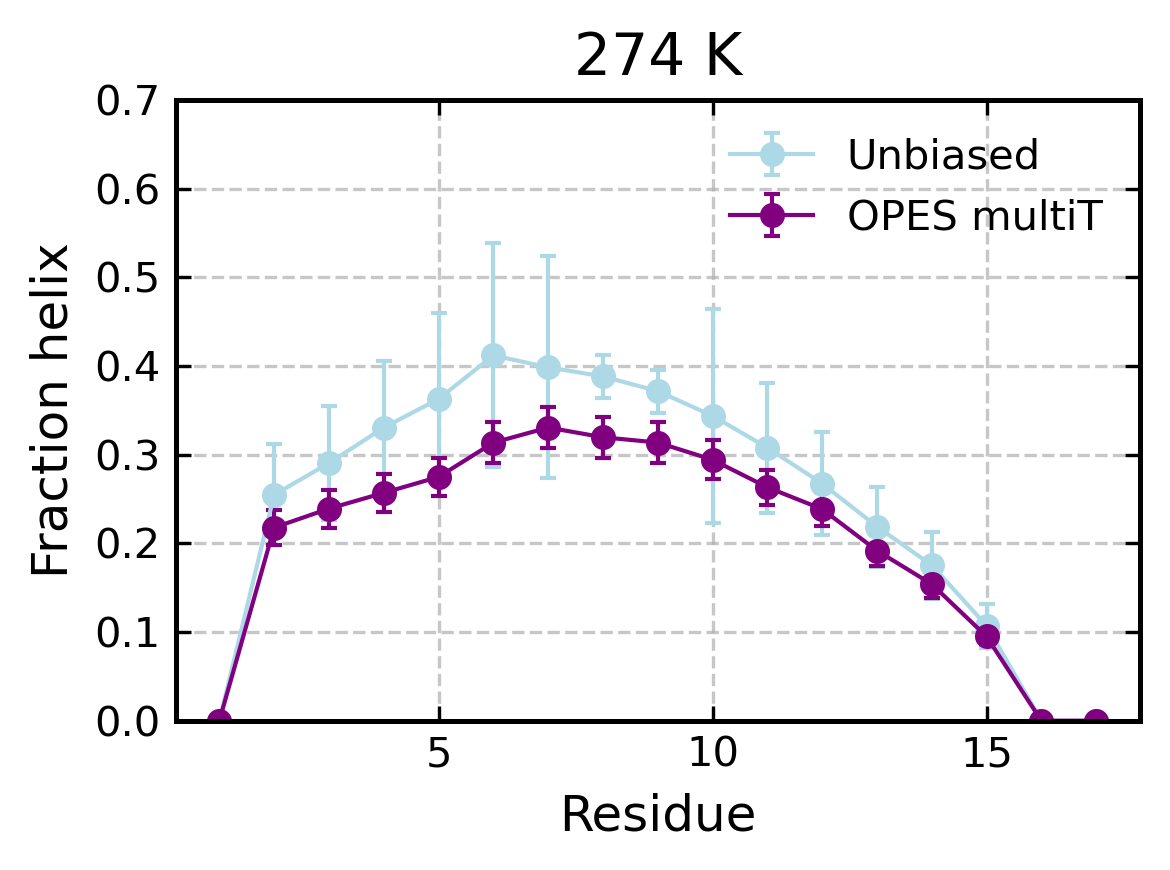

In [6]:
# Helicity at 274 K

nsims = 1
residues = np.arange(1, 17+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        
# helicity for all, concatenated frames
H = dssp_to_helicity(dssp)

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.mean(series)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction helix'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_helicity.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"274 K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='lightblue', label='Unbiased')
plt.xlabel("Residue")
plt.ylabel("Fraction helix")

# overlay OPES multiT for a comparison
dfopes = pd.read_csv(opes_data_path+'274K_noHMR_perres_helicity_274K.csv')
plt.errorbar(dfopes['Residue'], dfopes['Fraction helix'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label='OPES multiT')
plt.ylim(0,0.7)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_helicity.pdf")

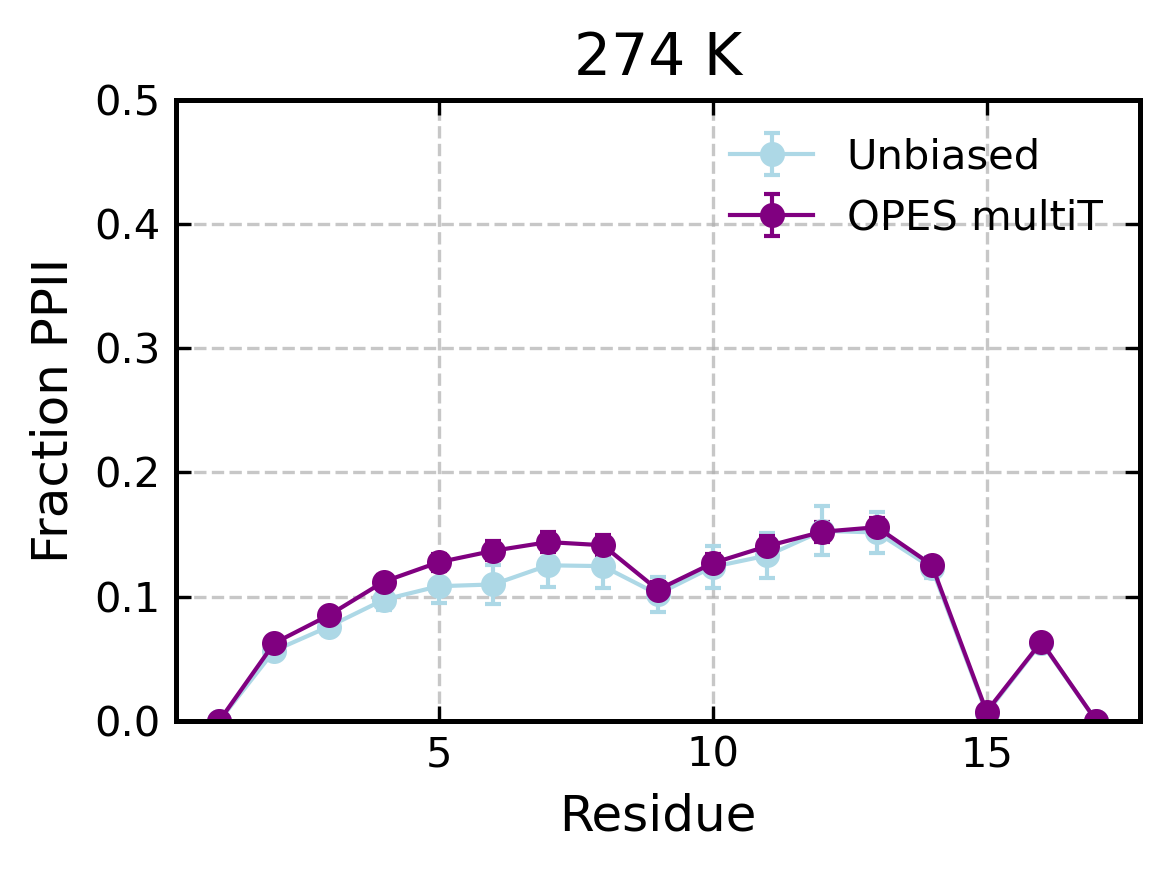

In [9]:
# PPII at 274 K

nsims = 1
residues = np.arange(1, 17+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        
# helicity for all, concatenated frames
H = dssp_to_PPII(dssp)

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.mean(series)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction helix'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_PPII.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"274 K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='lightblue', label='Unbiased')
plt.xlabel("Residue")
plt.ylabel("Fraction PPII")

# overlay OPES multiT for a comparison
dfopes = pd.read_csv(opes_data_path+'274K_noHMR_perres_PPII_274K.csv')
plt.errorbar(dfopes['Residue'], dfopes['Fraction helix'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label='OPES multiT')
plt.ylim(0,0.5)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_PPII.pdf")

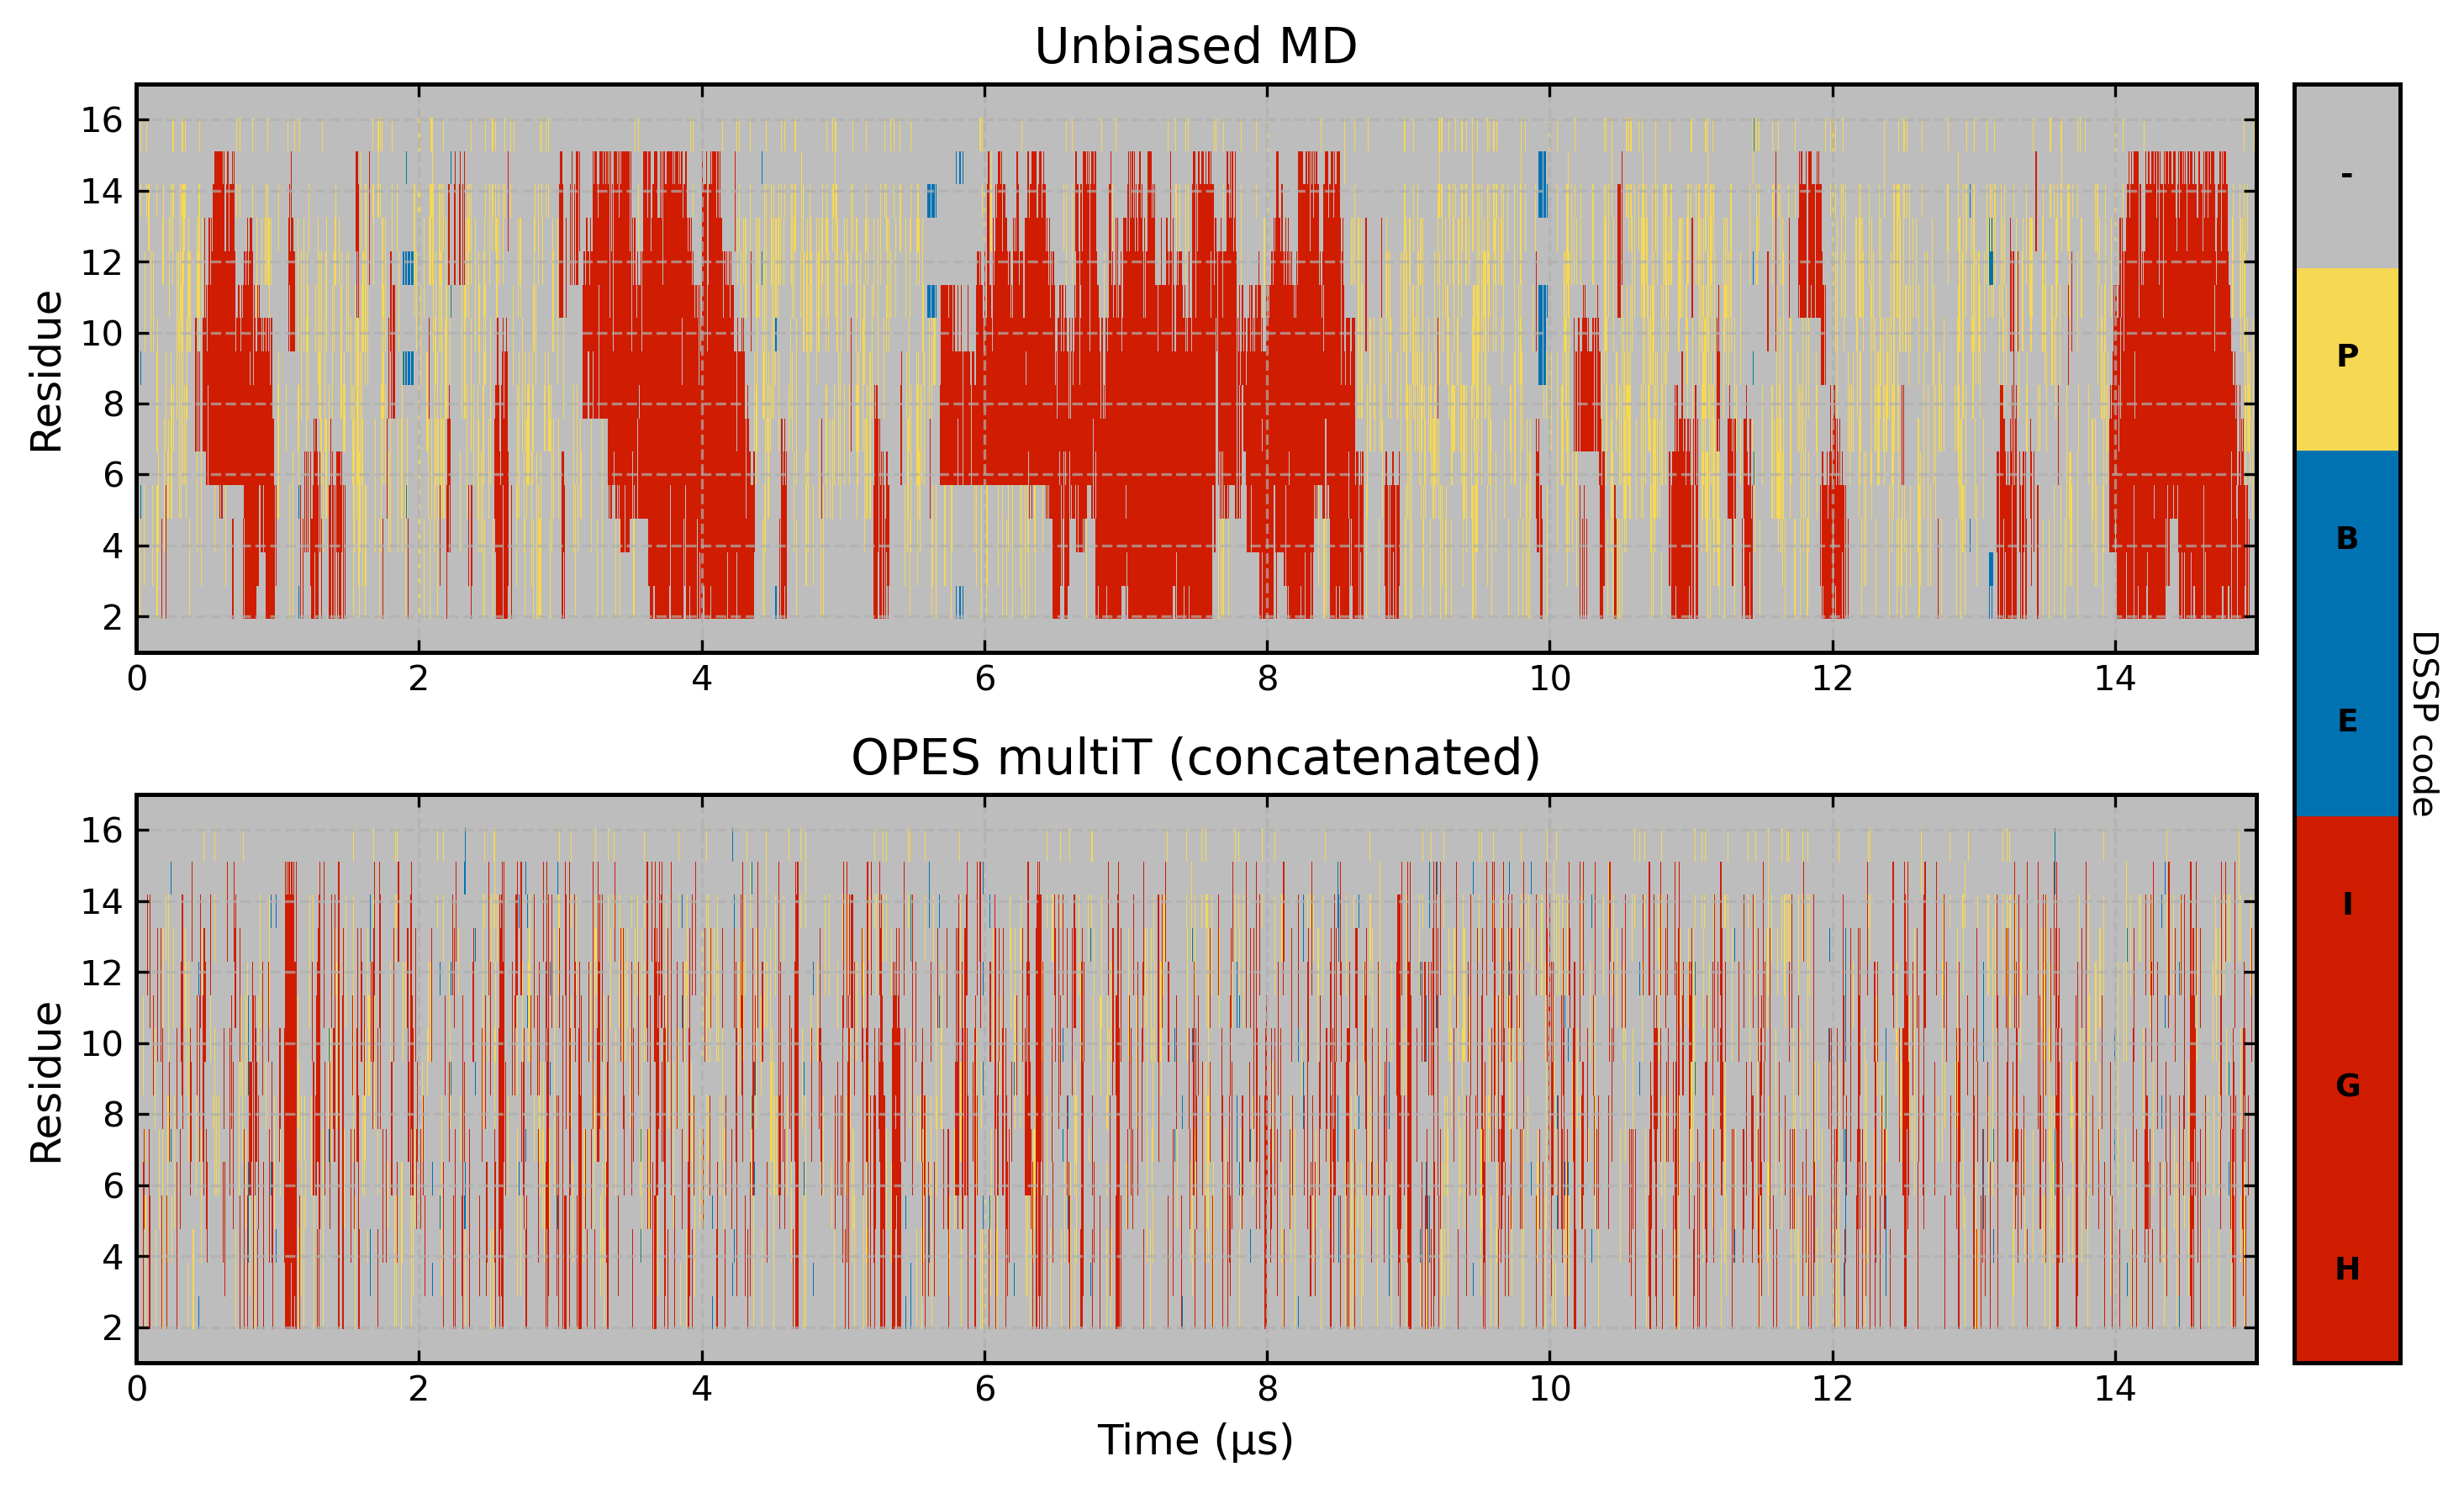

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

# --- Parameters ---
nsims_unbiased = 1
nsims_biased = 3

# --- DSSP codes & colors ---
dssp_codes = ["H", "G", "I", "E", "B", "P","-"]
colors = [
    "#D01C00",  # H
    "#D01C00",  # G
    "#D01C00",  # I
    "#0072B2",  # E
    "#0072B2",  # B
    "#F6D853",  # P
    "#BDBDBD"   # -
]
cmap = ListedColormap(colors)

# --- Map DSSP to integers ---
def map_dssp(arr):
    mapping = {code: i for i, code in enumerate(dssp_codes)}
    return np.vectorize(lambda x: mapping.get(x, len(dssp_codes)-1))(arr)

# --- Load unbiased data ---
for sim in range(nsims_unbiased):
    with open(path+f'dssp{sim}.dat') as f:
        tmpdssp = [list(line.strip()) for line in f]  # each row = residues at one frame
    tmpdssp = np.array(tmpdssp)
    time_data = np.arange(len(tmpdssp)) / 1e4  # µs
    mask = time_data <= 15.0
    tmpdssp = tmpdssp[mask]
    if sim == 0:
        dssp_unbiased = tmpdssp
    else:
        dssp_unbiased = np.concatenate((dssp_unbiased, tmpdssp), axis=0)

time_unbiased = np.arange(dssp_unbiased.shape[0]) / 1e4

# --- Load biased data ---
for sim in range(nsims_biased):
    with open(path_biased+f'dssp{sim}.dat') as f:
        tmpdssp = [list(line.strip()) for line in f]
    tmpdssp = np.array(tmpdssp)[::10]  # downsample by 10
    time_data = np.arange(len(tmpdssp)) / 1e4
    mask = time_data <= 5.0
    tmpdssp = tmpdssp[mask]
    if sim == 0:
        dssp_biased = tmpdssp
    else:
        dssp_biased = np.concatenate((dssp_biased, tmpdssp), axis=0)

time_biased = np.arange(dssp_biased.shape[0]) / 1e4

# --- Convert DSSP codes to integers ---
mat_unbiased = map_dssp(dssp_unbiased)
mat_biased = map_dssp(dssp_biased)

# --- Plot ---
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
cax = fig.add_subplot(gs[:, 1])  # colorbar column

# --- Heatmaps ---
im0 = ax0.imshow(mat_unbiased.T, aspect="auto", origin="lower",
                 extent=[time_unbiased[0], time_unbiased[-1], 1, mat_unbiased.shape[1]],
                 cmap=cmap, vmin=0, vmax=len(dssp_codes)-1, interpolation='none', rasterized=True)
ax0.set_ylabel("Residue")
ax0.set_title("Unbiased MD")

im1 = ax1.imshow(mat_biased.T, aspect="auto", origin="lower",
                 extent=[time_biased[0], time_biased[-1], 1, mat_biased.shape[1]],
                 cmap=cmap, vmin=0, vmax=len(dssp_codes)-1, interpolation='none', rasterized=True)
ax1.set_ylabel("Residue")
ax1.set_xlabel("Time (µs)")
ax1.set_title("OPES multiT (concatenated)")
ax1.set_xlim(0,15)

# --- Categorical colorbar with DSSP codes inside colored boxes ---
cax.set_xticks([])
cax.set_yticks([])
cax.set_xlim(0,1)
cax.set_ylim(0,len(dssp_codes))

for i, (color, code) in enumerate(zip(colors, dssp_codes)):
    cax.fill_between([0,1], i, i+1, color=color)
    cax.text(0.5, i + 0.5, code, ha="center", va="center", fontsize=9, fontweight="bold")

#cax.set_ylabel("DSSP code", rotation=270, labelpad=15)
# Label to the right of the colorbar
cax.text(1.05, len(dssp_codes)/2, 'DSSP code', rotation=270, va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_dssp_timecourse_heatmap.pdf", bbox_inches="tight")



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


<Figure size 1200x900 with 0 Axes>

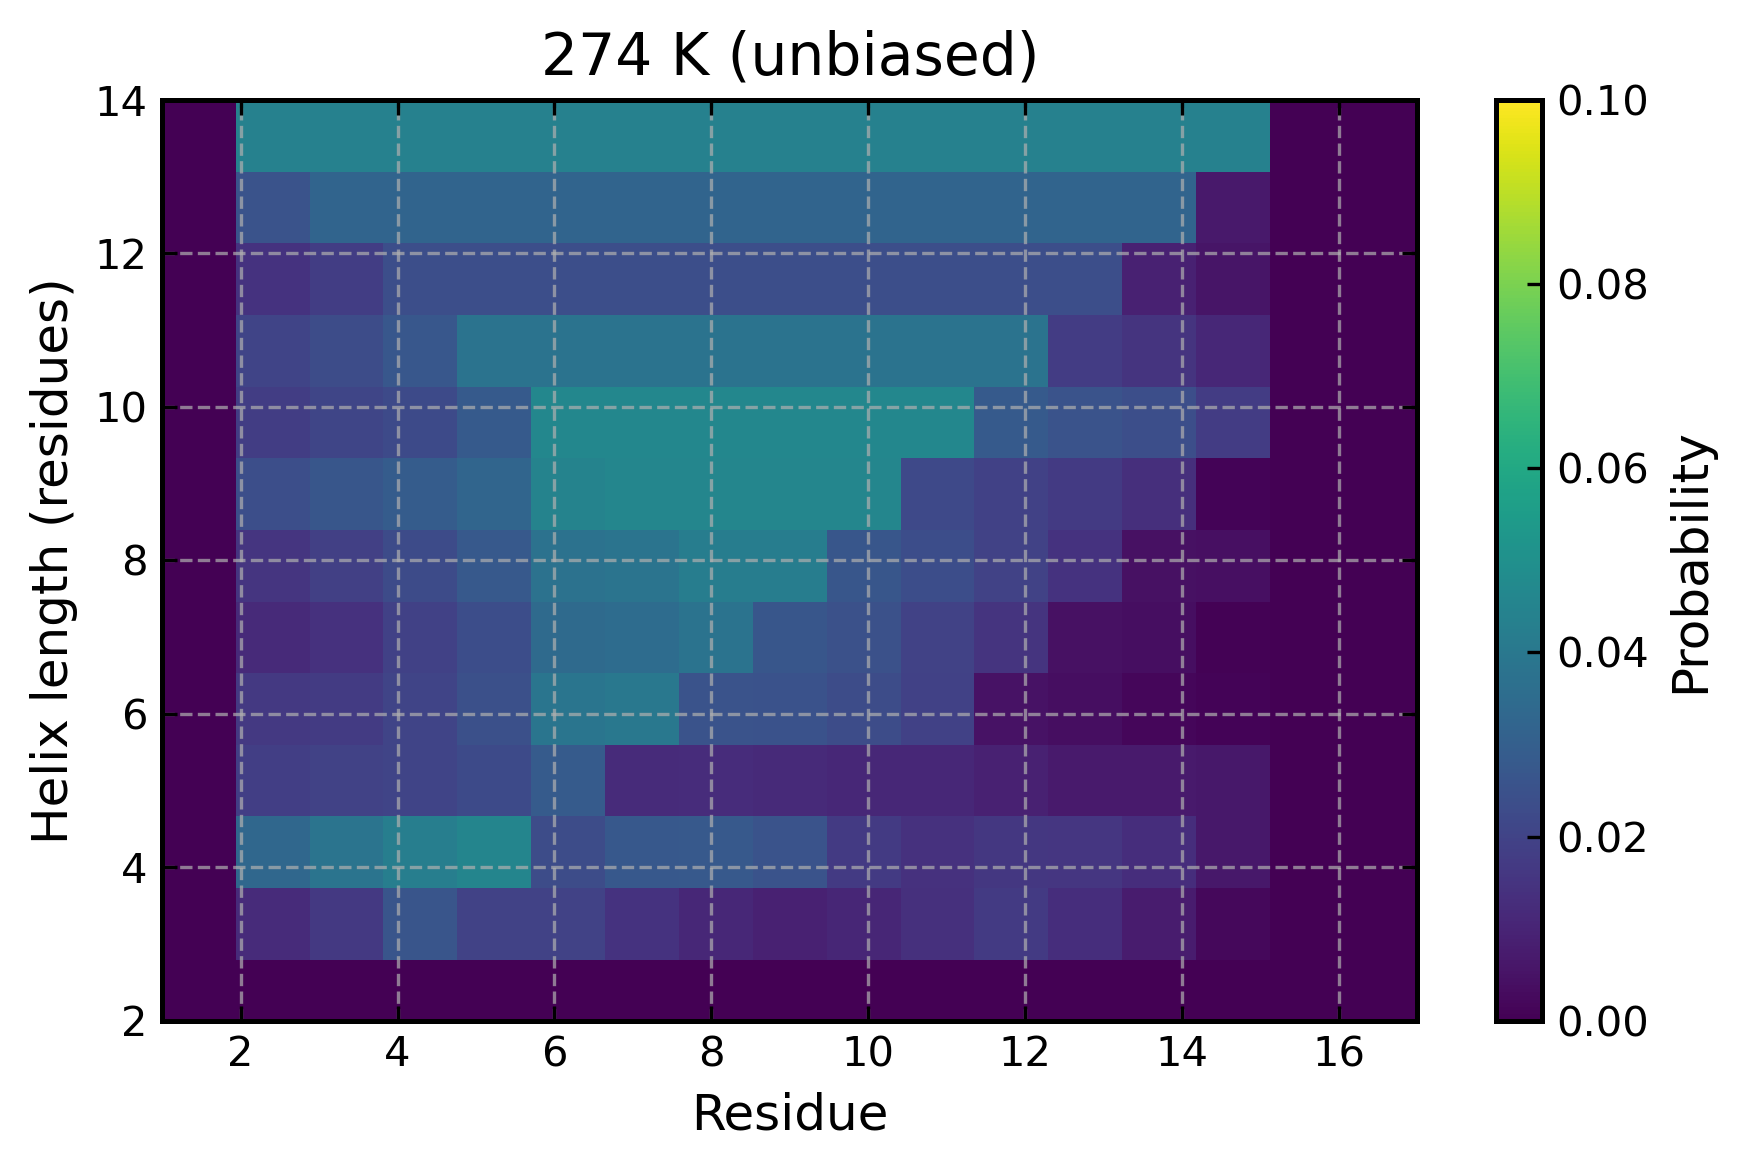

In [2]:
# 2D map: helix length vs residues 

nsims = 1
residues = np.arange(1, 17+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))/1e4
        # Apply cutoff at 15 µs
        mask_data = time_data <= 15.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# Convert DSSP codes to helix map: H=1, G=1, I=1, else 0
def dssp_to_helix_binary(dssp_lines):
    helix_codes = {'H', 'G', 'I'}
    arr = np.zeros((len(dssp_lines), len(residues)), dtype=int)
    for i, line in enumerate(dssp_lines):
        arr[i, :] = [1 if c in helix_codes else 0 for c in line]
    return arr

weights_clean = np.ones(dssp.shape[0]) / dssp.shape[0]
H = dssp_to_helix_binary(dssp)
n_frames, n_residues = H.shape

# Compute helix segment lengths per residue per frame
helix_lengths = np.zeros_like(H, dtype=int)
for i in range(n_frames):
    j = 0
    while j < n_residues:
        if H[i, j] == 1:
            # start of helix segment
            start = j
            while j < n_residues and H[i, j] == 1:
                j += 1
            seglen = j - start
            helix_lengths[i, start:j] = seglen
        else:
            j += 1

# Determine maximum helix length
max_len = np.max(helix_lengths)

# 2D probability map: length (y) vs residue (x)
prob_map = np.zeros((max_len + 1, n_residues))  # include length=0 for non-helical

for j in range(n_residues):
    for i in range(n_frames):
        L = helix_lengths[i, j]
        prob_map[L, j] += weights_clean[i]

# Normalize columns to get probabilities
prob_map /= prob_map.sum(axis=0, keepdims=True)

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(prob_map, origin='lower', aspect='auto', cmap='viridis',
           extent=[1, n_residues, 0, max_len])
plt.clim(0,0.1)
plt.ylim(2,14)
plt.colorbar(label='Probability')
plt.xlabel('Residue')
plt.ylabel('Helix length (residues)')
plt.title(f'274 K (unbiased)')
plt.tight_layout()
plt.savefig(output_path + f"{prod_name}_helix_length_map_274K.pdf")



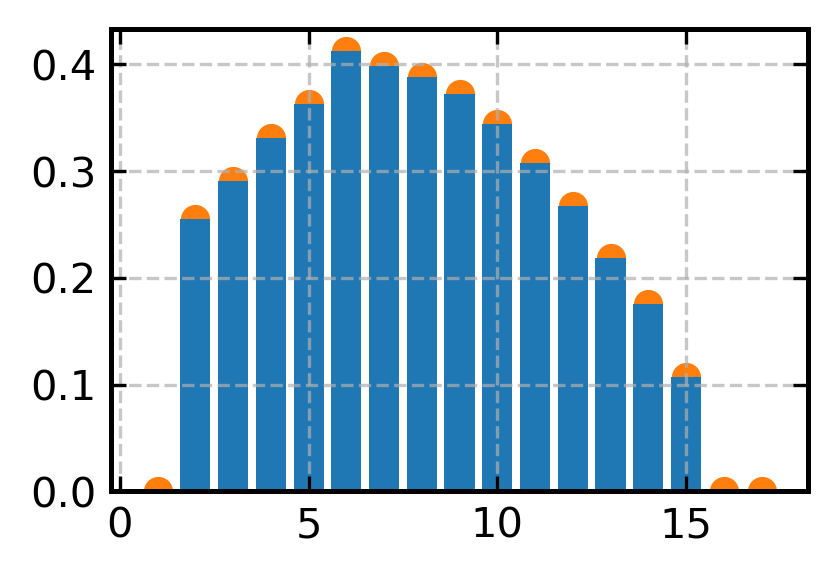

In [4]:
# sanity check that 2D map helix length vs residue correct and returns the same fraction helix per residue
df = pd.read_csv(output_path+f'{prod_name}_perres_helicity.csv')
plt.figure(figsize = (3,2))
plt.bar(residues, prob_map[1:].sum(axis=0))
plt.scatter(df['Residue'], df['Fraction helix'])